# Introduction

Proteins are like the "programs" that run biological processes in living organisms. Their ability to function depends on how their "code" (the sequence of amino acids) folds into a specific 3D structure. Protein Secondary Structure Prediction (PSSP) involves predicting the local structural elements (like helices, strands, and loops) of a protein based on its primary amino acid sequence. Traditionally, techniques like X-ray crystallography or NMR are used to solve the protein’s 3D structure, and from this, tools like DSSP assign secondary structure elements. However, these experimental methods are costly and timeconsuming.   

The goal of this assignment is to predict the secondary structure (sst3 and sst8 values) from just the primary sequence (seq) using deep learning techniques, which can significantly reduce the need for expensive lab work. In this task, secondary structure can be classified into eight categories (Q8) or simplified into three states (Q3), which offers different levels of granularity in prediction.   

**Interesting projects could involve:**
1. Developing deep learning techniques (such as RNNs, CNNs, or transformers) to predict the Q3 and Q8 secondary structures from the protein sequence. This will test your model's ability to handle both short- and long-range dependencies in the amino acid sequence.
2. Creating models that focus on improving Q3 and Q8 prediction by exploring novel architectures or feature representations.epresentations.

# Import Essential Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, Sequence

# Load and Explore the Dataset

We start by loading the dataset from a CSV file and examining its structure.

In [2]:
# Load the dataset from a CSV file
df = pd.read_csv('/kaggle/input/protein-structure/2018-06-06-pdb-intersect-pisces.csv')
df

,pdb_id,chain_code,seq,sst8,sst3,len,has_nonstd_aa,Exptl.,resolution,R-factor,FreeRvalue
0,1FV1,F,NPVVHFFKNIVTPRTPPPSQ,CCCCCBCCCCCCCCCCCCCC,CCCCCECCCCCCCCCCCCCC,20,False,XRAY,1.90,0.23,0.27
1,1LM8,H,DLDLEMLAPYIPMDDDFQLR,CCCCCCCCCBCCSCCCEECC,CCCCCCCCCECCCCCCEECC,20,False,XRAY,1.85,0.20,0.24
2,1O06,A,EEDPDLKAAIQESLREAEEA,CCCHHHHHHHHHHHHHHHTC,CCCHHHHHHHHHHHHHHHCC,20,False,XRAY,1.45,0.19,0.22
3,1QOW,D,CTFTLPGGGGVCTLTSECI*,CCTTSCTTCSSTTSSTTCCC,CCCCCCCCCCCCCCCCCCCC,20,True,XRAY,1.06,0.14,1.00
4,1RDQ,I,TTYADFIASGRTGRRNAIHD,CHHHHHHTSSCSSCCCCEEC,CHHHHHHCCCCCCCCCCEEC,20,False,XRAY,1.26,0.13,0.16
...,...,...,...,...,...,...,...,...,...,...,...
9073,4LGY,A,GDGLVPRGSHMMEILRGSPALSAFRINKLLARFQAANLQVHNIYAE...,CCEEEEETTEEEEEEEEEECCCHHHHHHHHHHHHHTTCCCCEEEEE...,CCEEEEECCEEEEEEEEEECCCHHHHHHHHHHHHHCCCCCCEEEEE...,1305,False,XRAY,1.48,0.14,0.17
9074,5XH6,A,GSHMTQFEGFTNLYQVSKTLRFELIPQGKTLKHIQEQGFIEEDKAR...,CCCCCCGGGCBSSSCEEEEEEEEEEECTTHHHHHHHHTHHHHHHHH...,CCCCCCHHHCECCCCEEEEEEEEEEECCCHHHHHHHHCHHHHHHHH...,1310,False,XRAY,2.00,0.18,0.21
9075,5B2R,B,GSGHMDKKYSIGLAIGTNSVGWAVITDEYKVPSKKFKVLGNTDRHS...,CCCCCCCCCEEEEEECSSEEEEEEECTTSCCCEEEEEEEESSSCCE...,CCCCCCCCCEEEEEECCCEEEEEEECCCCCCCEEEEEEEECCCCCE...,1372,False,XRAY,2.00,0.20,0.23
9076,5WLH,A,SNAMKISKVREENRGAKLTVNAKTAVVSENRSQEGILYNDPSRYGK...,CCCCCCCCCCCCCCCCCTTSSEEEEEEESSSCEEEEEEESSCCTTT...,CCCCCCCCCCCCCCCCCCCCCEEEEEEECCCCEEEEEEECCCCCCC...,1440,False,XRAY,1.80,0.19,0.22


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9078 entries, 0 to 9077
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pdb_id         9078 non-null   object 
 1   chain_code     9078 non-null   object 
 2   seq            9078 non-null   object 
 3   sst8           9078 non-null   object 
 4   sst3           9078 non-null   object 
 5   len            9078 non-null   int64  
 6   has_nonstd_aa  9078 non-null   bool   
 7   Exptl.         9078 non-null   object 
 8   resolution     9078 non-null   float64
 9   R-factor       9078 non-null   float64
 10  FreeRvalue     9078 non-null   float64
dtypes: bool(1), float64(3), int64(1), object(6)
memory usage: 718.2+ KB


# Data Preprocessing

There are 3 main steps for the data preprocessing:
1. **Remove duplicates**: Filter unique sequence and structure pairs.
2. **Tokenize sequences**: Convert amino acid sequences and secondary structure sequences to numerical indices.
3. **Padding and one-hot encoding**: Pad sequences to a uniform length and convert to one-hot encoded format for model input.

In [4]:
# Check the maximum sequence length
df['seq'].apply(len).max()

1632

In [5]:
# Remove duplicated rows for unique sequence/structure pairs
df = df.loc[:,['seq','sst8']].drop_duplicates() # Remove duplicated rows
print('There are {} unique seq / sst8 pairs.'.format(df.shape[0]))

There are 9078 unique seq / sst8 pairs.


In [6]:
# Extract sequences and secondary structures as arrays
seqs = df['seq'].values
target_sst8 = df['sst8'].values

In [7]:
# Tokenize the primary amino acid sequences
amino_acids = set(''.join(seqs))  # Set of all amino acids
aa_to_idx = {aa: idx+1 for idx, aa in enumerate(sorted(amino_acids))}
aa_to_idx['<PAD>'] = 0  # Padding token
padding_index = 0

In [8]:
aa_to_idx

{'*': 1,
 'A': 2,
 'C': 3,
 'D': 4,
 'E': 5,
 'F': 6,
 'G': 7,
 'H': 8,
 'I': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'P': 14,
 'Q': 15,
 'R': 16,
 'S': 17,
 'T': 18,
 'V': 19,
 'W': 20,
 'Y': 21,
 '<PAD>': 0}

All nonstandard amino acids, which includes B, O, U, X, and Z are masked with "*" character.

In [9]:
len(aa_to_idx)

22

In [10]:
# Function to encode input sequences as indices
def encode_sequence(input, input_to_idx):
    return [input_to_idx[aa] for aa in input]

In [11]:
# Encode all amino acid sequences
encoded_seqs = [encode_sequence(seq, aa_to_idx) for seq in seqs]

In [12]:
# Tokenize the sst8 values
sst8_structures = set(''.join(target_sst8))
sst8_to_idx = {ss: idx+1 for idx, ss in enumerate(sorted(sst8_structures))}
sst8_to_idx['<PAD>'] = 0  # Padding token

In [13]:
sst8_to_idx

{'B': 1, 'C': 2, 'E': 3, 'G': 4, 'H': 5, 'I': 6, 'S': 7, 'T': 8, '<PAD>': 0}

Now, we'll encode the amino acid and structure sequences and apply padding to make all sequences the same length.

In [14]:
# Encode all secondary structure sequences
encoded_sst8 = [encode_sequence(target, sst8_to_idx) for target in target_sst8]

In [15]:
# Get the number of unique tokens for input and target sequences
num_input_tokens = len(aa_to_idx)
num_target_tokens = len(sst8_to_idx)

In [16]:
# Function to pad and one-hot encode input sequences
def trans_seq_in(iseq):
    maxlen = max([len(txt) for txt in iseq]) # Get max sequence length
    print(maxlen)
    input_seq = pad_sequences(iseq, maxlen=maxlen, padding='post', value=0)
    return to_categorical(input_seq,num_classes=num_input_tokens)

# Function to pad and one-hot encode target sequences
def trans_seq_out(iseq):
    maxlen = max([len(txt) for txt in iseq])
    print(maxlen)
    target_seq = pad_sequences(iseq, maxlen=maxlen, padding='post', value=0)
    return to_categorical(target_seq,num_classes=num_target_tokens)

In [17]:
# Apply transformations to input and target sequences
X = trans_seq_in(encoded_seqs)
Y = trans_seq_out(encoded_sst8)

1632
1632


# Train, Validation, and Test Split

We split the dataset into training, validation, and test sets.

In [18]:
# Split data into train, val and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.1, random_state=42)

In [19]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((7262, 1632, 22),
 (7262, 1632, 9),
 (1634, 1632, 22),
 (1634, 1632, 9),
 (182, 1632, 22),
 (182, 1632, 9))

# Define Custom Dataset and DataLoader for PyTorch

In [20]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [21]:
# Define a custom dataset class for PyTorch
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

This custom dataset class enables the use of PyTorch's DataLoader to handle batches efficiently.

In [22]:
# Create DataLoaders
train_dataset = SequenceDataset(X_train, y_train)
val_dataset = SequenceDataset(X_val, y_val)
test_dataset = SequenceDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Seq2Seq Model

In [23]:
# Define the Seq2Seq model architecture
class Seq2SeqModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=100):
        super(Seq2SeqModel, self).__init__()
        # Bidirectional LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        # Fully connected layer to predict secondary structure
        self.dense = nn.Linear(hidden_size * 2, output_size)  # *2 for bidirectional

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dense(x)
        return x

# Training the Model with Early Stopping

To prevent overfitting, we use early stopping with `patience` = 3.

In [24]:
# Initialize model
num_input_tokens = len(aa_to_idx)
num_target_tokens = len(sst8_to_idx)
model = Seq2SeqModel(num_input_tokens, num_target_tokens)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping parameters
patience = 3
best_val_loss = float('inf')
patience_counter = 0

In [25]:
# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [26]:
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train() # Set model to training mode
    total_loss = 0
    correct_train = 0
    total_train = 0
    
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.view(-1, num_target_tokens)
        targets = targets.view(-1, num_target_tokens)
        
        # Calculate loss and backpropagate
        loss = criterion(outputs, targets.argmax(dim=-1).view(-1))
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Calculate training accuracy ignoring padding
        _, predicted = torch.max(outputs, dim=1)
        target_classes = targets.argmax(dim=-1).view(-1)
        valid_indices = target_classes != padding_index  # Mask for non-padding indices
        
        correct_train += (predicted[valid_indices] == target_classes[valid_indices]).sum().item()
        total_train += valid_indices.sum().item()  # Count only valid predictions

    # Compute average loss and accuracy for the epoch
    avg_loss = total_loss / len(train_loader)
    train_acc = correct_train / total_train if total_train > 0 else 0  # Prevent division by zero
    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)
    
    # Validation step
    model.eval() # Set model to evaluation mode
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            outputs = outputs.view(-1, num_target_tokens)
            targets = targets.view(-1, num_target_tokens)
            loss = criterion(outputs, targets.argmax(dim=-1).view(-1))
            val_loss += loss.item()
            
            # Calculate validation accuracy ignoring padding
            _, predicted = torch.max(outputs, dim=1)
            target_classes = targets.argmax(dim=-1).view(-1)
            valid_indices = target_classes != padding_index  # Mask for non-padding indices
            
            correct_val += (predicted[valid_indices] == target_classes[valid_indices]).sum().item()
            total_val += valid_indices.sum().item()  # Count only valid predictions

    # Calculate and store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct_val / total_val if total_val > 0 else 0  # Prevent division by zero
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    # Display training and validation metrics for the epoch
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch 1/50, Train Loss: 0.6008, Train Acc: 0.1481, Val Loss: 0.2568, Val Acc: 0.3202
Epoch 2/50, Train Loss: 0.2604, Train Acc: 0.3130, Val Loss: 0.2477, Val Acc: 0.3198
Epoch 3/50, Train Loss: 0.2372, Train Acc: 0.3922, Val Loss: 0.2283, Val Acc: 0.4332
Epoch 4/50, Train Loss: 0.2235, Train Acc: 0.4361, Val Loss: 0.2201, Val Acc: 0.4462
Epoch 5/50, Train Loss: 0.2174, Train Acc: 0.4514, Val Loss: 0.2144, Val Acc: 0.4664
Epoch 6/50, Train Loss: 0.2112, Train Acc: 0.4747, Val Loss: 0.2086, Val Acc: 0.4856
Epoch 7/50, Train Loss: 0.2066, Train Acc: 0.4891, Val Loss: 0.2048, Val Acc: 0.4960
Epoch 8/50, Train Loss: 0.2035, Train Acc: 0.4979, Val Loss: 0.2017, Val Acc: 0.5058
Epoch 9/50, Train Loss: 0.2003, Train Acc: 0.5072, Val Loss: 0.1989, Val Acc: 0.5128
Epoch 10/50, Train Loss: 0.1982, Train Acc: 0.5134, Val Loss: 0.1972, Val Acc: 0.5176
Epoch 11/50, Train Loss: 0.1970, Train Acc: 0.5151, Val Loss: 0.1968, Val Acc: 0.5170
Epoch 12/50, Train Loss: 0.1952, Train Acc: 0.5200, Val Loss: 0

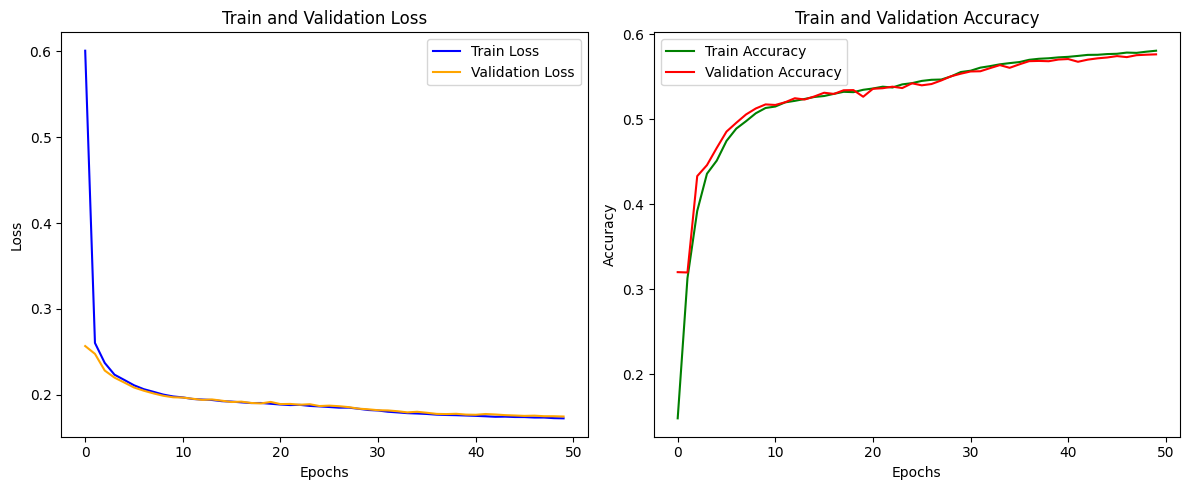

In [27]:
# Plotting the training and validation metrics
plt.figure(figsize=(12, 5))

# Plot for Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='green')
plt.plot(val_accuracies, label='Validation Accuracy', color='red')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Test and Evaluate Model Performance


Finally, we load the best model from training and evaluate its accuracy on the test set.

In [28]:
# Evaluation function
def evaluate_model(model, test_loader, padding_index=0):
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            outputs = outputs.view(-1, num_target_tokens)
            targets = targets.view(-1, num_target_tokens)

            # Calculate loss ignoring padding
            loss = criterion(outputs, targets.argmax(dim=-1).view(-1))
            test_loss += loss.item()

            # Calculate predictions and create a mask for valid indices
            _, predicted = torch.max(outputs, dim=1)
            target_classes = targets.argmax(dim=-1).view(-1)
            valid_indices = target_classes != padding_index  # Mask for non-padding indices

            # Calculate correct predictions ignoring padding
            correct_test += (predicted[valid_indices] == target_classes[valid_indices]).sum().item()
            total_test += valid_indices.sum().item()  # Count only valid predictions

    # Calculate and display the final test accuracy and loss
    avg_test_loss = test_loss / len(test_loader)
    test_acc = correct_test / total_test if total_test > 0 else 0  # Prevent division by zero

    return avg_test_loss, test_acc

In [29]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate on test set
test_loss, test_acc = evaluate_model(model, test_loader)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Test Loss: 0.1812, Test Acc: 0.5690


/tmp/ipykernel_129/2355148434.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


In [30]:
# Helper function to convert one-hot encoded sequence back to a string
def onehot_to_seq(oh_seq, index):
    s = ''
    for o in oh_seq:
        i = np.argmax(o)
        if i != 0:  # Ignore padding
            s += index[i]
        else:
            break
    return s

# Function to plot actual and predicted sequences side by side for comparison
def plot_results(x, y, y_, aa_to_idx, sst8_to_idx):
    # Reverse mappings for amino acids and sst8 structures
    reverse_aa_idx = {idx: aa for aa, idx in aa_to_idx.items()}
    reverse_sst8_idx = {idx: ss for ss, idx in sst8_to_idx.items()}
    
    print("---")
    print("Input Sequence: " + onehot_to_seq(x, reverse_aa_idx))
    print("Target Sequence: " + onehot_to_seq(y, reverse_sst8_idx))
    print("Predicted Sequence: " + onehot_to_seq(y_, reverse_sst8_idx))

    fig = plt.figure(figsize=(20, 10))
    
    # Plot the actual target sequence in blue
    plt.imshow(y.T, cmap='Blues')
    # Overlay the predicted sequence in red
    plt.imshow(y_.T, cmap='Reds', alpha=0.5)
    
    # Set y-ticks with corresponding labels for secondary structure states
    plt.yticks(range(len(sst8_to_idx) - 1), [reverse_sst8_idx[i + 1] for i in range(len(sst8_to_idx) - 1)])
    plt.xlabel('Position in Sequence')
    plt.title('Actual vs. Predicted Sequence (Blue: Actual, Red: Predicted)')
    plt.show()

In [31]:
# Define maximum sequence length for plotting
MAX_SEQ_LENGTH = 256

# Function to plot actual and predicted sequences side by side for comparison
def plot_results(x, y, y_, aa_to_idx, sst8_to_idx):
    # Reverse mappings for amino acids and sst8 structures
    reverse_aa_idx = {idx: aa for aa, idx in aa_to_idx.items()}
    reverse_sst8_idx = {idx: ss for ss, idx in sst8_to_idx.items()}

    # Convert sequences to strings
    input_seq = onehot_to_seq(x, reverse_aa_idx)[:MAX_SEQ_LENGTH]
    target_seq = onehot_to_seq(y, reverse_sst8_idx)[:MAX_SEQ_LENGTH]
    predicted_seq = onehot_to_seq(y_, reverse_sst8_idx)[:MAX_SEQ_LENGTH]

    print("---")
    print("Input Sequence: " + input_seq)
    print("Target Sequence: " + target_seq)
    print("Predicted Sequence: " + predicted_seq)

    # Truncate sequences to the maximum length for plotting
    x_truncated = x[:MAX_SEQ_LENGTH]
    y_truncated = y[:MAX_SEQ_LENGTH]
    y_reshaped = y_[:MAX_SEQ_LENGTH]

    fig = plt.figure(figsize=(10, 2))

    # Ensure y and y_ are in the right shape for imshow (2D)
    y_reshaped = y_reshaped.T  # Transpose the predicted sequence
    y_reshaped = np.expand_dims(y_reshaped, axis=0) if y_reshaped.ndim == 1 else y_reshaped

    # Plot the actual target sequence in blue
    plt.imshow(y_truncated.T, cmap='Blues')
    # Overlay the predicted sequence in red
    plt.imshow(y_reshaped, cmap='Reds', alpha=0.5)

    # Set y-ticks with corresponding labels for secondary structure states
    plt.yticks(range(len(sst8_to_idx) - 1), [reverse_sst8_idx[i + 1] for i in range(len(sst8_to_idx) - 1)])
    plt.xlabel('Position in Sequence')
    plt.title('Actual vs. Predicted Sequence (Blue: Actual, Red: Predicted)')
    plt.show()

Now, we will use visualize the predictions of 5 testing samples. The predictions are shown in red and the ground truth are shwon in blue.

Testing Results
Sequence 1 Accuracy: 66.86%
---
Input Sequence: GMNLQTDQTTTTADESAIRAFHRQMIDAWNRGSGEGFAAPFSETADFITFEGTHLKGRKEIAAFHQQAFDTVVKGTRLEGEVDFVRFVNSQLALMLVVIRVILPGQTETSASRDSLPLYVVTKGDEGWQIEGLLNTRKLTLERQFFLDDFDSLSAEAQRQVTDLVASLKQSH
Target Sequence: CCCCCCCCCCCHHHHHHHHHHHHHHHHHHHTTCHHHHHTTEEEEEEEECTTCCEEEHHHHHHHHHHHHHHTTTTTCEEEEEEEEEEEEETTEEEEEEEEEEECTTCSSBCGGGCBCCEEEEEEETTEEEEEEEECCBCCCHHHHHHHHHHHHSCHHHHHHHHHHHHHHTTCC
Predicted Sequence: CCCCCCCCCCCCCCHHHHHHHHHHHHHHHHTTCCCCCCCCCCCCCCEEEEETCECHHHHHHHHHHHHHHHEEEETEEEETEEEEEEEHHHTEEEEEEEEEEECCCCCCCCCCHCCCCEEEEEETCTSEEEEEEHHHHHHHHHHHHHHCCHCCHCHHHHHHHHHHHHHHCCCC


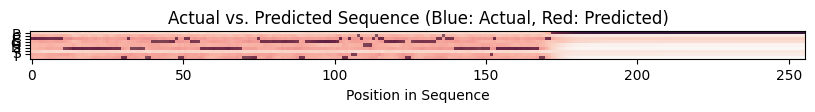

Sequence 2 Accuracy: 60.26%
---
Input Sequence: SNAMKTYIKRLNWEESIYLAINKLIAKHGKDNEAYNPDNKPFAVFDWDNTSIIGDVEEALLYYMVRNVSFKMDPEEFYELIRKNVDRKDYPKEFNNLDKQRVNIDLISQDIKRAYEKLYKNLDRFEGGKTLEEVQDTDYYQEFVSKMLYRYRASEFDPEAEDPYCWMSFLLKNYKTEEVYDLCKGAYASMKKERIRVEEFVSPDIKSEAGRISIKYFVGIRTLDEMVDLYRSLEENGIDCYIVSASFIDIVRAFAT
Target Sequence: CCCCCCCSCCTTCCHHHHHHHHHHHHHHSTTSTTCCTTSEEEEEECCTTTTEESCHHHHHHHHHHHHTCCCCCHHHHHHHHHTTBCCSCCCGGGCCTTSCCCCHHHHHHHHHHHHHHHHHHBTTTTSCBCSGGGTTSHHHHHHHHHHHHHHHHCCBCTTSSSSCCSGGGGGTTCCHHHHHHHHHHHHHHHTTSCCEEEEEECCSSCCSSCCCEEEEEECCEECHHHHHHHHHHHHTTCEEEEEEEEEHHHHHHHHH
Predicted Sequence: CCCCCCHEECCCHHHHHHHHHHHHHHHTCCCCHCCCTTSCCEEEECTTTTCEHHHHHHHHHHHHHHHCCCCCCHHHHHHHHHHTCCHTCCCHHHHCHHHHHCHHHHHHHHHHHHHHHHHHHHHHCTTCCCCHHHCCHHHHHHHHHHHHHHHHHCCCCTTCCCHHHHHHHHHHTCCHHHHHHHHHHHHHHHHHHCEHHEEECCHCHCHHTTCEEEEEEEHHHHHHHHHHHHHHHHHTTCCEEEEEHHHHHHHHHHHH


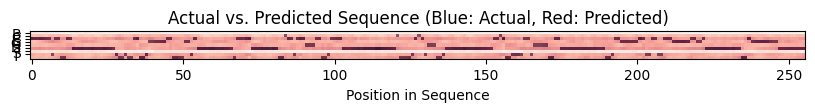

Sequence 3 Accuracy: 60.62%
---
Input Sequence: RKLPVFKSLRHMRQVLGAPSFRMLAWHVLMGNQVIWKSRDVDLVQSAFEVLRTMLPVGCVRIIPYSSQYEEAYRCNFLGLSPHVQIPPHVLSSEFAVIVEVHAAARSTLHPVGAEDDQSLSKYEFVVTSGSPVAADRVGPTILNKIEAALTNQNLSVDVVDQALVALKEEWMNKVKVLFKFTKVDSRPKEDTQKLLSILGASEEDNVKLLKFWMTGLSKTYKSHLM
Target Sequence: CCCCSCCCHHHHHHHHCHHHHHHHHHHHHTTCEEEEECSCHHHHHHHHHHHGGGSCGGGCCEEEEESSCCCTTTCSEEEECTTCCCCHHHHTCTTEEEEEEECCCCCCCCCCCCCCCCCCTTCEEEEEESSCTTTTSSCCHHHHHHHHHHHCTTSCHHHHHHHHHHHHHHHHHHHHHHHHHTCCCCCCHHHHHHHHHHTTCCSHHHHHHHHHHGGGTCCCCCCCCC
Predicted Sequence: CCCCCCCCHHHHHHHHTCCCHHHHHHHHHHTCEEEEHCTCHHHHHHHHHHHHHHCCTTEEEEECCCSHHHHHHHHHHTTCCCTCCCCCGCCCHHHHHHEHHHHHHHHCCCCCCCCCCHCHCHHEEEEETSCHHHHHHHCHHHHHHHHHHHHHTTCCHHHHHHHHHHHHHHHHHHHHEEEEEEECCSCCCHCHHHHHHHHTCCCHHHHHHHHHHHHHHCHHHCCCCC


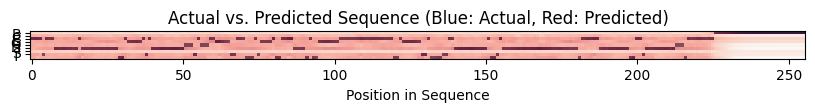

Sequence 4 Accuracy: 53.57%
---
Input Sequence: GAASMEEPGAEEVRILFSTAKGESHTHKAGFKQLFRRLRSTYRPDKVDKDDFTLDTLRSAHILVLGGPKEKFTAPEVDMLKKFVKNGGSILILMSEGGEEKAGTNINYFLEQFGMSVNNDAVVRTTHYKYLHPKEVLISDGILNRAVITGAGKSLNSNDDDEFRVSRGPQAFDGTGLEYVFPFGATLSVQKPAVPVLSSGKIAYPMNRPVGAVWAQPGYGRIAVLGSCAMFDDKWLDKEENSKIMDFFFKFLEPHS
Target Sequence: CCCCCCCCCCCCCEEEEECTTCCSSBTTTBCHHHHHHHTTTSEEEEECGGGCSHHHHHTCSEEEEESCCSCCCHHHHHHHHHHHHTTCEEEEECCTTHHHHHTCCTHHHHGGGTEEECSCCCEESSCCTTCCTTEEEESSCBCSGGGTCCCCCCCCCCCCCCTTCCCCCCCCCSCSCCEEEESCCCEEECTTSEEEEECCTTEESTTCEEEEEEECTTSCEEEEESCSGGGSTTTTTSTTHHHHHHHHHHHHSTTC
Predicted Sequence: CCCCCCCCCCCCEEEEEECCTCCCCCHHHHHHHHHHHHHHTCCCCCCCTTCCHHHHHHHCEEEEECCCTGCCCCHHHHHHHHHHHTTCCEEEEEETSCCHHTTHHHHHHHHHHTCCEETCEEEEEEEEEEECCCEEEEETTEEEEEEEECTCCEECCCCTSEEEEEECCEECTTTEEEEEEETTCEEEEECCCCCEEETSEEEECTSCCCEEEEECTTTEEEEEEEEEEEECHTTCCHHHHHHHHHHHEHHCCTTC


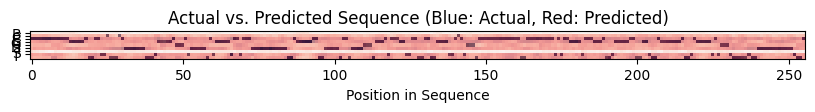

Sequence 5 Accuracy: 53.90%
---
Input Sequence: MASAELAKPLTLDQLQQQNGKAIDTRPSAFYNGWPQTLNGPSGHELAALNLSASWLDKMSTEQLNAWIKQHNLKTDAPVALYGNDKDVDAVKTRLQKAGLTHISILSDALSEPSRLQKLPHFEQLVYPQWLHDLQQGKEVTAKPAGDWKVIEAAWGAPKLYLISHIPGADYIDTNEVESEPLWNKVSDEQLKAMLAKHGIRHDTTVILYGRDVYAAARVAQIMLYAGVKDVRLLDGGWQTWSDAGLPVERGTPPKV
Target Sequence: CCCCCCCSCBCHHHHHHTTCEEEECSCHHHHHTCCSSTTCCCSBCTTCEECCGGGGGGCCHHHHHHHHHHTTCCTTSCEEEESCHHHHHHHHHHHHHTTCCCEEEBTTTTSCGGGCBCCTTGGGEECHHHHHHHHTTCCCTTCCSSCEEEEEEESSSCSHHHHCBCTTCEEEEGGGTEETTTTEECCHHHHHHHHHHTTCCTTSEEEEECSSHHHHHHHHHHHHHHTCSCEEEETTTHHHHHHTTCCCBCSSCCCC
Predicted Sequence: CCCCCCCCCCCHHHHHHHTCCCCCCCCCHHHTTCCHCCCCCCSHHHHHHHHHHHHHHHHHHHHHHHHHHHHTCCCSCCEEEECCCSCHHHHHHHHHHHTCCEEEEECCCCCCHHHHHHCCCCEEEHHHHHHHHHHTTCEEEECCTTCHHHHHHHHTCCEEEEEEECCTCGECCHCCCCCCCCCCHCCHHHHHHHHHHTTCCEEEEEEEECSHHHHHHHHHHHHHHHTCCEEEEEESSCCCCCHTTCCCCTCCCCCC


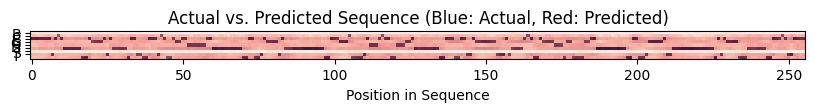

In [35]:
# Set the model to evaluation mode
model.eval()

# Evaluate on a few test sequences
N = 5  # Number of sequences to predict
with torch.no_grad():  # Disable gradient calculation for inference
    # Convert to PyTorch tensor and ensure it is on the correct device
    X_test_tensor = torch.tensor(X_test[:N], dtype=torch.float32).to(device)  # Convert and move to device
    y_test_pred = model(X_test_tensor)  # Get predictions

# Convert the predictions to a more interpretable format
y_test_pred = y_test_pred.cpu().numpy()  # Move predictions back to CPU if needed

# Assuming y_test_pred is in one-hot format, convert to class indices
predicted_classes = np.argmax(y_test_pred, axis=-1)  # Convert to class indices

padding_index = 0

# Calculate accuracy for each sequence
accuracies = []
print('Testing Results')
for i in range(N):
    # Calculate target classes
    target_classes = np.argmax(y_test[i], axis=-1)  # Assuming y_test is also one-hot encoded
    
    # Create a mask for non-padding indices
    valid_indices = target_classes != padding_index
    
    # Calculate correct predictions only for valid (non-padding) indices
    correct_predictions = (predicted_classes[i][valid_indices] == target_classes[valid_indices])
    
    # Calculate accuracy based on valid predictions
    accuracy = np.sum(correct_predictions) / len(correct_predictions)  # Calculate accuracy
    accuracies.append(accuracy)  # Store accuracy

    # Print accuracy
    print(f'Sequence {i + 1} Accuracy: {accuracy:.2%}')  # Print accuracy as a percentage
    plot_results(X_test[i], y_test[i], y_test_pred[i], aa_to_idx, sst8_to_idx)  # Use y_test_pred for visualization

# Conclusion

In this notebook, we implemented a bidirectional LSTM model to predict secondary protein structure (Q8). We trained the model, evaluated it, and applied early stopping to prevent overfitting. Overall, this project has demonstrated the potential of deep learning for bioinformatics applications, particularly in protein structure prediction. While our current model performs reasonably well, it also highlights the complexities of biological sequences and the need for more advanced architectures and techniques to fully capture these complexities.